# Code Explanation: Creating a Network Graph from CSV Data

This code aims to create a network graph from the given CSV data containing information about users, tasks, and their interactions. The code uses various Python libraries like NumPy, Pandas, and NetworkX.

## Importing Libraries
- `numpy as np`: Used for numerical computations and arrays.
- `pandas as pd`: Used for data processing and handling CSV files.
- `os`: Operating system interface for handling file paths.
- `networkx as nx`: A Python library for the creation, manipulation, and study of the structure, dynamics, and functions of complex networks.

## Reading Data
The code reads two CSV files, 'colab_train.csv' and 'colab_test.csv', using Pandas. It loads the training data into the `train` DataFrame and the test data into the `test` DataFrame. Both DataFrames are then concatenated into a single DataFrame called `data`.

## Extracting User Information
1. The unique user IDs are extracted from the `data` DataFrame and stored in the `nodes` array.
2. A dictionary called `node_dict` is created to store information about each user. The user ID serves as the key, and the value is another dictionary containing various attributes of the user.
3. The following attributes are computed and stored for each user:
   - `org_times`: The number of times the user organized a task.
   - `times_of_participation`: The number of unique tasks the user participated in.
   - `task_longitude`: The average longitude of tasks organized by the user.
   - `task_latitude`: The average latitude of tasks organized by the user.
   - `user_location`: The most common location ID of the user.

## Encoding User Locations
A dictionary called `location_dict` is created to map unique user locations to numeric indices. This dictionary is used to encode the `user_location` attribute in the `data` DataFrame with corresponding numeric values.

## Creating the Network Graph
1. A NetworkX graph called `graph` is initialized.
2. Nodes are added to the graph, where each node represents a user. Node attributes are set to the computed values from the `node_dict`.
3. An edge dictionary `edge_dict` is created to store the number of interactions between pairs of users.
4. For each unique task in the `data` DataFrame, the code extracts the participating users and creates edges between all pairs of users who participated in the same task. The weight of each edge represents the number of times the users interacted in different tasks.

## Adding Edges to the Network Graph
1. The code iterates through the `edge_dict` to add the edges and their weights to the `graph`.

The resulting `graph` object represents a network graph where users are nodes, and interactions between users are represented as edges with weights indicating the number of interactions between them.

In [1]:
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import networkx as nx

In [2]:
# Read the training data from 'colab_train.csv' and test data from 'colab_test.csv'
train = pd.read_csv('colab_train.csv')
test = pd.read_csv("colab_test.csv", usecols=train.columns)

In [3]:
# Combine the training and test data into a single DataFrame called 'data'
data = pd.concat([train, test], ignore_index=True)

In [4]:
# Extract unique user IDs from the combined data
nodes = data.user_id.unique()

# Create a dictionary 'node_dict' to store attributes for each user
node_dict = {}

# Calculate and store attributes for each user in 'node_dict'
for u in nodes:
    d = data[data.user_id == u]
    node_dict[u] = {}
    
    # Store the number of times the user organized a task
    node_dict[u]['org_times'] = d.is_organizer.sum()
    
    # Store the number of unique tasks the user participated in
    node_dict[u]['times_of_participation'] = d.task_id.unique().shape[0]
    
    # Store the average longitude of tasks organized by the user
    node_dict[u]['task_longitude'] = d.longitude.mean()
    
    # Store the average latitude of tasks organized by the user
    node_dict[u]['task_latitude'] = d.latitude.mean()

# Create a dictionary 'location_dict' to map unique user locations to numeric indices
location_dict = dict([(addr, i) for i, addr in enumerate(data.user_location.unique())])

# Encode 'user_location' with corresponding numeric values using 'location_dict'
data['user_location'] = data.apply(lambda x: location_dict[x['user_location']], axis=1)

# Further update the 'node_dict' with the most common location ID for each user
for u in nodes:
    d = data[data.user_id == u]
    node_dict[u]['user_location'] = d.user_location.mode()[0]

In [5]:
# Create a NetworkX graph called 'graph' to represent the user network
graph = nx.Graph()

# Add nodes to the graph, each representing a user with their respective attributes
for user, attr in node_dict.items():
    graph.add_node(user,
                   org_times=attr['org_times'],
                   join_times=attr['times_of_participation'],
                   loc=attr['user_location'],
                   longitude=attr['task_longitude'],
                   latitude=attr['task_latitude']
                   )

# Create a dictionary 'edge_dict' to store the number of interactions between user pairs
edge_dict = {}

# Iterate through each unique task to identify interactions between users
for t in data.task_id.unique():
    task = data[data.task_id == t]
    users = list(task.user_id.unique())

    # For each pair of participants, create an edge between them
    for i in range(len(users)):
        for j in range(i + 1, len(users)):
            u, v = users[i], users[j]
            if (u, v) not in edge_dict and (v, u) not in edge_dict:
                edge_dict[(u, v)] = 1
            elif (u, v) in edge_dict:
                edge_dict[(u, v)] += 1
            else:
                edge_dict[(v, u)] += 1

# Add edges to the NetworkX graph, representing interactions with their weights
for e, w in edge_dict.items():
    graph.add_edge(e[0], e[1], weight=w)

## Code Explanation: Generating and Splitting Node Pairs for Graph Data

This code performs several tasks related to processing a given graph data represented using NetworkX library.

### Generating Node Pairs and Weights

1. `itertools.combinations(graph.nodes, 2)` is used to generate all possible pairs of nodes from the graph. This step ensures that every possible edge (node pair) is considered for the dataset. The resulting pairs are stored in the `node_pairs` list.

2. An empty list `edge_list` is initialized to store each node pair along with its weight. The weight of an edge is set to 1 if it exists between the two nodes, and 0 if no edge is present.

3. The code iterates through each node pair in `node_pairs`. For each pair, it checks if there is an edge between the two nodes using `graph.has_edge(u, v)` function.

4. If an edge exists (i.e., there is a connection between the nodes), the pair and its corresponding weight (1) are appended to the `edge_list`.

5. If no edge exists between the nodes, the pair and a weight of 0 are appended to the `edge_list`.

### Creating DataFrame and Data Splitting

6. A Pandas DataFrame `df` is created to store the node pairs and their corresponding weights. This DataFrame serves as the dataset for further analysis or machine learning tasks.

7. The code then splits the dataset into training, testing, and validation sets using `train_test_split()` from scikit-learn. The parameter `test_size` controls the proportion of the dataset assigned to each split.

8. The resulting training, testing, and validation datasets are exported to separate CSV files: 'Data_split_train.csv', 'Data_split_test.csv', and 'Data_split_val.csv' respectively.

The main purpose of this code is likely to prepare the dataset for a machine learning task, where the goal is to predict the presence or absence of edges between nodes in the given graph.

In [11]:
import itertools
from sklearn.model_selection import train_test_split

# Get all possible pairs of nodes from the graph
node_pairs = list(itertools.combinations(graph.nodes, 2))

# Initialize a list to store node pairs and their corresponding weights
edge_list = []

# Iterate through each pair of nodes
for u, v in node_pairs:
    # Check if there is an edge between the two nodes
    if graph.has_edge(u, v):
        # If an edge exists, get the weight of the edge
        weight = graph.get_edge_data(u, v)['weight']
        
        # Check if the weight is greater than 0
        if weight > 0:
            # If the weight is greater than 0, set it to 1
            weight = 1
        else:
            # If the weight is not greater than 0, set it to 0
            weight = 0
            
        edge_list.append((u, v, weight))
    else:
        # If no edge exists, set the weight to 0
        edge_list.append((u, v, 0))

# Create a Pandas DataFrame to store the node pairs and their weights
df = pd.DataFrame(edge_list, columns=['Node1', 'Node2', 'Weight'])

# Split the dataset into training, testing, and validation sets with shuffling
train, temp = train_test_split(df, test_size=0.3, random_state=42, shuffle=True)
test, val = train_test_split(temp, test_size=0.5, random_state=42, shuffle=True)

# Export the datasets to CSV files
train.to_csv('Data_split_train.csv', index=False)
test.to_csv('Data_split_test.csv', index=False)
val.to_csv('Data_split_val.csv', index=False)

# Comparing coefficients for link pridiction
Comparing AAI Jaccard coefficient and CNC in AUC-ROC, P@K and AUPR

In [12]:
def precision_at_k(y_true, y_scores, k):
    """
    Function to calculate precision at k.

    Parameters:
        y_true (list): Actual labels
        y_scores (list): Predicted scores
        k (int): The cut-off rank (k)

    Returns:
        float: Precision at rank k
    """

    # Sort y_scores and y_true in descending order of y_scores
    sorted_indexes = np.argsort(y_scores)[::-1]
    y_scores_sorted = y_scores[sorted_indexes]
    y_true_sorted = y_true[sorted_indexes]

    # Calculate precision at k
    precision = sum(y_true_sorted[:k]) / k

    return precision

In [13]:
from sklearn.metrics import roc_curve, auc, roc_auc_score, average_precision_score

def evaluate_performance(df, ground_truth_column, prediction_column, k):
    """
    Function to evaluate the performance of the predictions using AUC-ROC and P@K.
    """

    # Calculate the AUC-ROC
    auc_roc = roc_auc_score(df[ground_truth_column], df[prediction_column])

    # Print the AUC-ROC score
    print(f"AUC-ROC: {auc_roc}")

    # Calculate the Precision at K
    p_at_k = precision_at_k(df[ground_truth_column].values, df[prediction_column].values, k)
    
    # Print the P@K score
    print(f"Precision at K={k}: {p_at_k}")
    
    # Calculate the Area Under Precision-Recall curve (AUPR)
    aupr = average_precision_score(df[ground_truth_column], df[prediction_column])
    
    # Print the AUPR score
    print(f"Area Under Precision-Recall curve (AUPR): {aupr}")

    # Plot the ROC curve
    #fpr, tpr, _ = roc_curve(df[ground_truth_column], df[prediction_column])
    #plt.figure()
    #lw = 2  # line width
    #plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % auc_roc)
    #plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    #plt.xlim([0.0, 1.0])
    #plt.ylim([0.0, 1.05])
    #plt.xlabel('False Positive Rate')
    #plt.ylabel('True Positive Rate')
    #plt.title('Receiver Operating Characteristic')
    #plt.legend(loc="lower right")
    #plt.show()

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

def calculate_cnc(file_path, graph):
    """
    Function to calculate Common Neighbors Count (CNC)
    for each pair of nodes in a given file and graph.
    """

    # Load the data from the file
    df = pd.read_csv(file_path)
    
    cnc_values = []
    
    # Iterate over each row in the dataframe
    for index, row in df.iterrows():
        u, v = row['Node1'], row['Node2']
        
        # Get the neighbors of each node
        u_neighbors = set(graph.neighbors(u))
        v_neighbors = set(graph.neighbors(v))
        
        # Calculate the common neighbors count (CNC)
        common_neighbors = len(u_neighbors.intersection(v_neighbors))
        
        # Add the CNC to the list
        cnc_values.append(common_neighbors)

    # Add the CNC values as a new column to the dataframe
    df['CNC'] = cnc_values

    return df


# Process the files
for file_path in ['Data_split_train.csv', 'Data_split_test.csv', 'Data_split_val.csv']:
    # Calculate the CNC values
    df = calculate_cnc(file_path, graph)
    
    # Evaluate the performance
    evaluate_performance(df, 'Weight', 'CNC', k=50)

    # Save the dataframe to a new csv file
    df.to_csv(file_path.replace('.csv', '_cnc.csv'), index=False)

AUC-ROC: 0.9959479364522148
Precision at K=50: 1.0
Area Under Precision-Recall curve (AUPR): 0.8705086191599317
AUC-ROC: 0.9966070470515924
Precision at K=50: 1.0
Area Under Precision-Recall curve (AUPR): 0.8731565291156204
AUC-ROC: 0.9951151327784071
Precision at K=50: 1.0
Area Under Precision-Recall curve (AUPR): 0.8701088231760461


In [16]:
# Calculate the CNC values
for file in ['Data_split_train.csv', 'Data_split_test.csv', 'Data_split_val.csv']:
    data_with_cnc = calculate_cnc(file, graph)
    
    data_with_cnc.drop_duplicates(subset=['CNC', 'Weight'], inplace=True)
    # Save the dataframe to a new csv file
    data_with_cnc.to_csv(file.replace('.csv', '_cnc_drop.csv'), index=False)

In [17]:
# Load the data with CNC values
df = pd.read_csv('Data_split_train_cnc_drop.csv')

# Evaluate the performance of the CNC calculation
evaluate_performance(df, 'Weight', 'CNC', k=10)

AUC-ROC: 0.6468446601941747
Precision at K=10: 1.0
Area Under Precision-Recall curve (AUPR): 0.7728183940053687


In [42]:
# Load the data with CNC values
df = pd.read_csv('Data_split_test_cnc_drop.csv')

# Evaluate the performance of the CNC calculation
evaluate_performance(df, 'Weight', 'CNC', k=10)

AUC-ROC: 0.6473684210526316
Precision at K=10: 1.0
Area Under Precision-Recall curve (AUPR): 0.7703288609037781


In [43]:
# Load the data with CNC values
df = pd.read_csv('Data_split_val_cnc_drop.csv')

# Evaluate the performance of the CNC calculation
evaluate_performance(df, 'Weight', 'CNC', k=10)

AUC-ROC: 0.6832292595896521
Precision at K=10: 1.0
Area Under Precision-Recall curve (AUPR): 0.8167663076551868


In [18]:
import pandas as pd
import matplotlib.pyplot as plt
from networkx import jaccard_coefficient
from sklearn.metrics import roc_curve, auc, roc_auc_score

def calculate_jaccard(file_path, graph):
    """
    Function to calculate Jaccard Coefficient
    for each pair of nodes in a given file and graph.
    """

    # Load the data from the file
    df = pd.read_csv(file_path)
    
    predictions = []
    
    # Iterate over each row in the dataframe
    for index, row in df.iterrows():
        u, v = row['Node1'], row['Node2']
        
        # Calculate the Jaccard Coefficient
        score = jaccard_coefficient(graph, [(u, v)])
        
        # Add the score to the predictions list
        predictions.append([p for i,j,p in score][0])

    # Add the predictions as a new column to the dataframe
    df['Jaccard'] = predictions

    # Drop duplicates where Jaccard and weight are the same
    df.drop_duplicates(subset=['Jaccard', 'Weight'], keep='first', inplace=True)

    return df


# Process the files
for file_path in ['Data_split_train.csv', 'Data_split_test.csv', 'Data_split_val.csv']:
    # Calculate the Jaccard Coefficients
    df = calculate_jaccard(file_path, graph)
    
    # Evaluate the performance
    evaluate_performance(df, 'Weight', 'Jaccard', k=50)

    # Save the dataframe to a new csv file
    df.to_csv(file_path.replace('.csv', '_jaccard.csv'), index=False)

AUC-ROC: 0.7477528124886331
Precision at K=50: 0.94
Area Under Precision-Recall curve (AUPR): 0.7858435226488587
AUC-ROC: 0.834942050228922
Precision at K=50: 0.98
Area Under Precision-Recall curve (AUPR): 0.8472208549491151
AUC-ROC: 0.8323476535347754
Precision at K=50: 0.94
Area Under Precision-Recall curve (AUPR): 0.8414361415224966


In [19]:
# List of file paths
file_paths = ['Data_split_train.csv', 'Data_split_test.csv', 'Data_split_val.csv']

# Calculate Jaccard Coefficient for each file
for file_path in file_paths:
    df = calculate_jaccard(file_path, graph)
    df.to_csv(file_path.split('.')[0] + '_jaccard_drop.csv', index=False)

In [20]:
# Load the data with Jaccard values
df = pd.read_csv('Data_split_train_jaccard_drop.csv')

# Evaluate the performance of the Jaccard Coefficient calculation
evaluate_performance(df, 'Weight', 'Jaccard', k=10)

AUC-ROC: 0.7477528124886331
Precision at K=10: 0.8
Area Under Precision-Recall curve (AUPR): 0.7858435226488587


In [44]:
# Load the data with Jaccard values
df = pd.read_csv('Data_split_test_jaccard_drop.csv')

# Evaluate the performance of the Jaccard Coefficient calculation
evaluate_performance(df, 'Weight', 'Jaccard', k=10)

AUC-ROC: 0.834942050228922
Precision at K=10: 0.9
Area Under Precision-Recall curve (AUPR): 0.8472208549491151


In [45]:
# Load the data with Jaccard values
df = pd.read_csv('Data_split_val_jaccard_drop.csv')

# Evaluate the performance of the Jaccard Coefficient calculation
evaluate_performance(df, 'Weight', 'Jaccard', k=10)

AUC-ROC: 0.8323476535347754
Precision at K=10: 0.8
Area Under Precision-Recall curve (AUPR): 0.8414361415224966


## Function Explanation: Calculating Adamic-Adar Index for Node Pairs in a Graph

The provided function, `calculate_adamic_adar_index(G, node_pairs)`, computes the Adamic-Adar index for a given list of node pairs in a NetworkX graph.

### Function Parameters:

- `G` (NetworkX graph): The input graph on which the Adamic-Adar index will be computed.
- `node_pairs` (list of tuples): A list containing tuples of node pairs for which the index will be calculated.

### Return Value:

The function returns a list containing the Adamic-Adar index for each node pair in the same order as they appear in the input list.

### Adamic-Adar Index:

The Adamic-Adar index is a measure of similarity between two nodes in a graph based on their shared neighbors. It is often used in social network analysis and link prediction tasks.

### Function Implementation:

1. The function initializes an empty list called `adamic_adar_index` to store the calculated index for each node pair.

2. It then iterates through each node pair in the `node_pairs` list.

3. For each node pair, the function initializes a variable `index` to 0, which will accumulate the Adamic-Adar index for the current pair.

4. It finds the common neighbors between the two nodes in the current pair using the `nx.common_neighbors()` function from NetworkX.

5. For each common neighbor, the function calculates the contribution to the Adamic-Adar index. It does this by adding the reciprocal of the logarithm of the degree of that common neighbor to the `index`. The logarithm of the degree is used to assign higher weight to common neighbors with lower degrees, emphasizing the importance of rare common neighbors.

6. After considering all the common neighbors, the function stores the computed Adamic-Adar index for the current node pair in the `adamic_adar_index` list.

7. The function repeats the process for each node pair in the input list, accumulating the index values in the `adamic_adar_index` list.

8. Finally, the function returns the list `adamic_adar_index`, which contains the Adamic-Adar index values for each node pair in the same order as they were provided.

The Adamic-Adar index is a useful metric in various graph-based applications, particularly in tasks involving link prediction, recommendation systems, and similarity-based analysis in social networks.

In [21]:
def calculate_adamic_adar_index(G, node_pairs):
    """
    Calculate Adamic-Adar index for given node pairs in the graph G.

    Parameters:
        G (NetworkX graph): The input graph.
        node_pairs (list of tuples): A list of tuples containing node pairs for which to calculate the index.

    Returns:
        list: A list containing the Adamic-Adar index for each node pair.
    """
    adamic_adar_index = []

    # Iterate through each node pair in the list
    for pair in node_pairs:
        index = 0
        common_neighbors = list(nx.common_neighbors(G, pair[0], pair[1]))

        # Calculate the Adamic-Adar index for the current node pair
        for node in common_neighbors:
            # Add the reciprocal of the logarithm of the degree of the common neighbor
            index += 1 / np.log(G.degree(node))

        # Store the calculated index for the current node pair
        adamic_adar_index.append(index)

    # Return the list containing the Adamic-Adar index for each node pair
    return adamic_adar_index

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score

def calculate_adamic_adar(file_path, graph):
    """
    Function to calculate Adamic Adar Index for each pair of nodes in a given file and graph.
    """

    # Load the data from the file
    df = pd.read_csv(file_path)
    
    # Get the node pairs from the dataframe
    node_pairs = [(row['Node1'], row['Node2']) for _, row in df.iterrows()]
    
    # Calculate the Adamic Adar Index
    adamic_adar_index = calculate_adamic_adar_index(graph, node_pairs)

    # Add the Adamic Adar Index as a new column to the dataframe
    df['AdamicAdar'] = adamic_adar_index

    return df

# Process the files
for file_path in ['Data_split_train.csv', 'Data_split_test.csv', 'Data_split_val.csv']:
    # Calculate the Adamic Adar Index
    df = calculate_adamic_adar(file_path, graph)
    
    # Evaluate the performance
    evaluate_performance(df, 'Weight', 'AdamicAdar', k=50)

    # Save the dataframe to a new csv file
    df.to_csv(file_path.replace('.csv', '_adar.csv'), index=False)

AUC-ROC: 0.9963361532823463
Precision at K=50: 1.0
Area Under Precision-Recall curve (AUPR): 0.9069394015277974
AUC-ROC: 0.9969860863019904
Precision at K=50: 1.0
Area Under Precision-Recall curve (AUPR): 0.9092878303769005
AUC-ROC: 0.9954839708759364
Precision at K=50: 1.0
Area Under Precision-Recall curve (AUPR): 0.9064111571396146


In [23]:
# Read the training data containing node pairs and weights from 'Data_split_train.csv'
weight_train = pd.read_csv('Data_split_train.csv')  # Calculate Adamic-Adar index

In [24]:
# Extract node pairs from the DataFrame for Adamic-Adar index calculation
node_pairs = [(row['Node1'], row['Node2']) for _, row in weight_train.iterrows()]

# Calculate the Adamic-Adar index for the node pairs using the given graph
adamic_adar_index = calculate_adamic_adar_index(graph, node_pairs)

# Add the computed Adamic-Adar index as a new column 'AAI' to the DataFrame
weight_train['AAI'] = adamic_adar_index

# Save the DataFrame with the added Adamic-Adar index to a new CSV file
weight_train.to_csv('Data_split_train_weight_AAI.csv', index=False)  # Read CSV file


In [25]:
# Read the CSV file into a new DataFrame for further processing
df = pd.read_csv('Data_split_train_weight_AAI.csv')

# Remove duplicate rows and keep only the 'Weight' and 'AAI' columns
df = df[['Weight', 'AAI']].drop_duplicates()

# Save the processed DataFrame with removed duplicates to a new CSV file
df.to_csv('Data_split_train_weights_AAI_drop.csv', index=False)

In [26]:
weight_test = pd.read_csv('Data_split_test.csv')

In [27]:
# Calculate the Adamic-Adar index for the node pairs using the given graph
node_pairs = [(row['Node1'], row['Node2']) for _, row in weight_test.iterrows()]
adamic_adar_index = calculate_adamic_adar_index(graph, node_pairs)
weight_test['AAI'] = adamic_adar_index

weight_test.to_csv('Data_split_train_weight_AAI.csv', index=False)

In [28]:
df = pd.read_csv('Data_split_train_weight_AAI.csv')

df = df[['Weight', 'AAI']].drop_duplicates()

df.to_csv('Data_split_test_weights_AAI_drop.csv', index=False)

In [51]:
# Import the pandas library
import pandas as pd

# Load the validation data from the csv file
val_weight = pd.read_csv('Data_split_val.csv')

# Compute the Adamic-Adar index for all node pairs in the validation data
node_pairs = [(row['Node1'], row['Node2']) for _, row in val_weight.iterrows()]
adamic_adar_index = calculate_adamic_adar_index(graph, node_pairs)

# Add the computed Adamic-Adar index to the validation data
val_weight['AAI'] = adamic_adar_index

# Save the updated validation data to a new csv file
val_weight.to_csv('Data_split_val_weight_AAI.csv', index=False)

In [54]:
# Load the data with Jaccard values
df = pd.read_csv('Data_split_train_weights_AAI_drop.csv')

# Evaluate the performance of the Jaccard Coefficient calculation
evaluate_performance(df, 'Weight', 'AAI', k=10)

AUC-ROC: 0.8571129093878355
Precision at K=10: 1.0
Area Under Precision-Recall curve (AUPR): 0.9098937583153444


In [50]:
# Load the data with Jaccard values
df = pd.read_csv('Data_split_test_weights_AAI_drop.csv')

# Evaluate the performance of the Jaccard Coefficient calculation
evaluate_performance(df, 'Weight', 'AAI', k=10)

AUC-ROC: 0.8897074768052127
Precision at K=10: 1.0
Area Under Precision-Recall curve (AUPR): 0.9107033233168178


In [55]:
# Load the data with Jaccard values
df = pd.read_csv('Data_split_val_weight_AAI.csv')

df = df[['Weight', 'AAI']].drop_duplicates()

# Evaluate the performance of the Jaccard Coefficient calculation
evaluate_performance(df, 'Weight', 'AAI', k=10)

AUC-ROC: 0.8878190779178073
Precision at K=10: 1.0
Area Under Precision-Recall curve (AUPR): 0.9095577831788417


# Model Training and Evaluation

1. **Reads in the training and testing data:** The training and testing data are read from 'Data_split_train_weights_AAI_drop.csv' and 'Data_split_test_weights_AAI_drop.csv' respectively.

2. **Defines the features and target variable:** The feature used for model training is 'AAI' (Adamic-Adar index) and the target variable is 'Weight'.

3. **Trains different models:** The models used for training include Random Forest, SVM with Grid Search for hyperparameter tuning, Gradient Boosting Classifier, and XGBoost Classifier. Each of these models is trained on the training data.

4. **Evaluates the performance of the models:** The performance of each model is evaluated on the testing data. This helps understand how well the model will perform on unseen data.

5. **Prints the model performance scores and classification reports:** The model performance scores (such as precision, recall, f1-score, etc.) and classification reports for each model are printed to understand their performance in a more detailed manner.

In [35]:
# Import the required libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report


# Read the training and testing datasets
train_data = pd.read_csv('Data_split_train_weights_AAI_drop.csv')
test_data = pd.read_csv('Data_split_test_weights_AAI_drop.csv')

# Define the features (X) and target variable (y) for training data
X_train = train_data[['AAI']]  # Features (Adamic-Adar index)
y_train = train_data['Weight']  # Target variable (Weight)

# Define the features (X) and target variable (y) for testing data
X_test = test_data[['AAI']]  # Features (Adamic-Adar index)
y_test = test_data['Weight']  # Target variable (Weight)

# Model Training
model = RandomForestClassifier(n_estimators=100, random_state=50)
model.fit(X_train, y_train)

# 在测试集上评估模型
y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.84      0.81      2920
           1       0.87      0.83      0.85      3923

    accuracy                           0.84      6843
   macro avg       0.83      0.84      0.83      6843
weighted avg       0.84      0.84      0.84      6843



In [30]:
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# 定义特征和目标变量
X_train = train_data[['AAI']]
y_train = train_data['Weight']

X_test = test_data[['AAI']]
y_test = test_data['Weight']

# 创建SVM模型
from sklearn.model_selection import GridSearchCV

# 使用最佳参数训练模型
model = svm.SVC(C=0.1, kernel='rbf', degree=3, gamma=1)

# 训练模型
model.fit(X_train, y_train)

# 在测试集上评估模型
y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.75      0.78      2920
           1       0.82      0.87      0.84      3923

    accuracy                           0.82      6843
   macro avg       0.82      0.81      0.81      6843
weighted avg       0.82      0.82      0.82      6843



In [31]:
# Import the required libraries
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report

# Define the features (X) and target variable (y) for training data
features = ['Adamic_Adar_Index']
target = 'colab'

# Define the features (X) and target variable (y) for testing data
X_train = train_data[['AAI']]
y_train = train_data['Weight']

X_test = test_data[['AAI']]
y_test = test_data['Weight']

# Model Training
model = GradientBoostingClassifier(random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

# Model Evaluation
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.76      0.78      2920
           1       0.83      0.86      0.85      3923

    accuracy                           0.82      6843
   macro avg       0.82      0.81      0.81      6843
weighted avg       0.82      0.82      0.82      6843



In [32]:
# Import the required libraries
#import xgboost as xgb
#from sklearn.metrics import classification_report

# Define the features (X) and target variable (y) for training data
#X_train = train_data[['AAI']]
#y_train = train_data['Weight']

#X_test = test_data[['AAI']]
#y_test = test_data['Weight']

# Model Training
#model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
#model.fit(X_train, y_train)


#y_pred = model.predict(X_test)

# Model Evaluation
#print(classification_report(y_test, y_pred))

This piece of code carries out the concept of stacking in machine learning. Stacking is an ensemble learning technique that uses predictions from multiple models (base models) to build a new model (meta-model). This new model is used for making predictions on the test set.

The steps in this code are:

1. **Define features and target variable**: The feature matrix (`X_train` and `X_test`) and the target variable (`y_train` and `y_test`) for both the training and testing datasets are defined.

2. **Initialize base models**: Three different base models are initialized, which include RandomForestClassifier, Support Vector Machine (SVC), and GradientBoostingClassifier.

3. **Train base models**: Each of the base models is trained on the training data.

4. **Generate base model predictions**: Predictions are generated from each base model on both the training and testing datasets.

5. **Stack base model predictions**: The predictions from all base models for both the training and testing datasets are stacked together.

6. **Initialize and train meta-model**: A meta-model (in this case, XGBoost) is initialized and then trained on the stacked predictions from the base models.

7. **Generate final predictions**: The meta-model is used to generate the final predictions on the test dataset.

8. **Evaluate model performance**: A classification report is generated and printed, showing precision, recall, f1-score, and support for each class. Also, the accuracy of the final predictions is calculated and printed.

This code calculates Adamic-Adar Index for the validation set, then uses base models and a meta-model in a stacking ensemble to predict the target variable on the validation set. The predictions are then evaluated using a classification report, accuracy score, and an ROC curve.

In [57]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

# Define features and target variable
X_train = train_data[['AAI']]
y_train = train_data['Weight']

X_test = test_data[['AAI']]
y_test = test_data['Weight']

#Create and train base models
model1 = RandomForestClassifier(n_estimators=100, random_state=50)
model2 = svm.SVC(C=0.1, kernel='rbf', degree=3, gamma=1)
model3 = GradientBoostingClassifier(random_state=42)

model1.fit(X_train, y_train)
model2.fit(X_train, y_train)
model3.fit(X_train, y_train)

#Make predictions on the training and test sets
train_pred1 = model1.predict(X_train)
train_pred2 = model2.predict(X_train)
train_pred3 = model3.predict(X_train)

test_pred1 = model1.predict(X_test)
test_pred2 = model2.predict(X_test)
test_pred3 = model3.predict(X_test)

#Use predictions as new features
stacked_train_predictions = np.column_stack((train_pred1, train_pred2, train_pred3))
stacked_test_predictions = np.column_stack((test_pred1, test_pred2, test_pred3))

#Create and train the meta-model
meta_model = RandomForestClassifier(n_estimators=100, random_state=50)
meta_model.fit(stacked_train_predictions, y_train)

#Make predictions on the test set using the meta-model
final_predictions = meta_model.predict(stacked_test_predictions)

#Output the classification report for the predictions
print(classification_report(y_test, final_predictions))

#Calculate and print the model accuracy
accuracy = accuracy_score(y_test, final_predictions)
print(f"Model accuracy: {accuracy}")

              precision    recall  f1-score   support

           0       0.79      0.84      0.81      2920
           1       0.87      0.83      0.85      3923

    accuracy                           0.84      6843
   macro avg       0.83      0.84      0.83      6843
weighted avg       0.84      0.84      0.84      6843

Model accuracy: 0.835452287008622


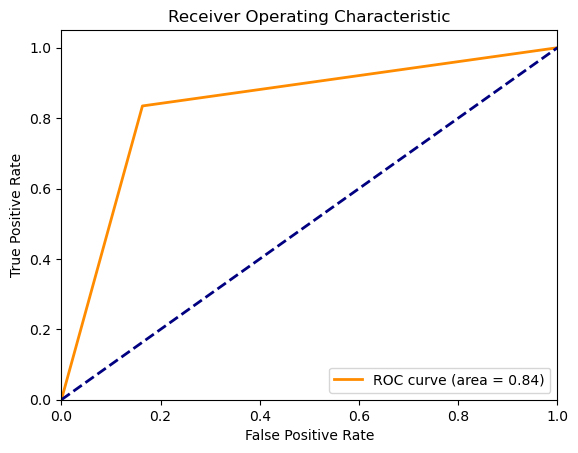

In [58]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Compute the false positive rate, true positive rate and thresholds for the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, final_predictions)

# Compute the area under the ROC curve
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Applying the Stacking Ensemble Framework to the Validation Dataset

This code block performs the following steps:

1. **Load the Validation Data:** It reads in the validation data from a CSV file.

2. **Calculate Adamic-Adar Index:** For each pair of nodes in the validation data, it calculates the Adamic-Adar index. This index is then added as a new column in the validation data. The updated validation data is saved to a new CSV file.

3. **Predict with Base Models:** The Adamic-Adar index values are extracted from the validation data and used as input to the base models (the same models trained in the stacking ensemble framework). Each base model makes predictions on the validation data.

4. **Create New Features:** The predictions made by each of the base models on the validation data are stacked together to form a new set of features.

5. **Predict with Meta-Model:** These new features are then used as input to the meta-model, which makes the final predictions on the validation data.

6. **Add Predictions to Data:** The final predictions are added to the validation data as a new column and the updated validation data is printed and saved to a new CSV file.

7. **Evaluate Model Performance:** The predictions are extracted from the validation data along with the actual target values. A classification report is printed to provide detailed performance metrics. The overall accuracy of the predictions is also calculated and printed. Furthermore, an ROC curve is plotted and the area under the ROC curve is computed to provide another performance metric for the model.

This code demonstrates the application of the stacking ensemble framework to the validation dataset and the evaluation of its performance.

In [39]:
# Load the updated validation data
df = pd.read_csv('Data_split_val_weight_AAI.csv')

# Extract the Adamic-Adar index as input feature
X_new = df[['AAI']]

# Use the base models to make predictions on the validation data
new_pred1 = model1.predict(X_new)
new_pred2 = model2.predict(X_new)
new_pred3 = model3.predict(X_new)

# Stack the predictions from the base models
stacked_new_predictions = np.column_stack((new_pred1, new_pred2, new_pred3))

# Use the meta-model to make final predictions on the validation data
final_new_predictions = meta_model.predict(stacked_new_predictions)

# Add the final predictions to the validation data
df['Predicted'] = final_new_predictions

# Print the validation data with the predictions
print(df)

# Save the validation data with the predictions to a new csv file
df.to_csv('Data_split_val_VS_AAI.csv', index=False)

         Node1   Node2  Weight       AAI  Predicted
0       137679  148743       0  0.000000          0
1       117198   80830       0  0.000000          0
2        51794   68441       0  0.000000          0
3        67923  172715       0  0.000000          0
4        98364  142102       0  0.000000          0
...        ...     ...     ...       ...        ...
536467  120513   65549       0  0.000000          0
536468   98243  154341       0  0.800926          1
536469  162843    7430       0  0.000000          0
536470   60315  115687       0  0.000000          0
536471  103827   70594       0  0.000000          0

[536472 rows x 5 columns]


In [59]:
# Load the validation data with the predictions
df = pd.read_csv('Data_split_val_VS_AAI.csv')

df = df[['Weight', 'AAI','Predicted']].drop_duplicates()

# Extract the predictions and the actual target values
predictions = df[['Predicted']]
y_test = df[['Weight']]

# Print the classification report for the predictions
print(classification_report(y_test, predictions))

# Compute and print the accuracy of the predictions
accuracy = accuracy_score(y_test, predictions)
print(f"Model accuracy: {accuracy}")

              precision    recall  f1-score   support

           0       0.80      0.84      0.82      2918
           1       0.87      0.84      0.85      3806

    accuracy                           0.84      6724
   macro avg       0.83      0.84      0.84      6724
weighted avg       0.84      0.84      0.84      6724

Model accuracy: 0.8372992266508031


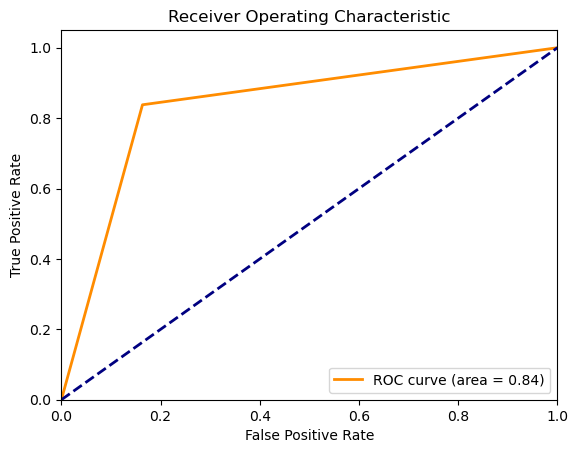

In [60]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Compute the false positive rate, true positive rate and thresholds for the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, predictions)

# Compute the area under the ROC curve
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# AAI Model Training -- best resolution

1. **Load test candidate multistep dataset:** The testing data are read from 'test candidate multistep dataset.csv'.

2. **Caculate:** The feature used for model training is 'AAI' (Adamic-Adar index) and the target variable is 'Weight'.

3. **AAI model training:** The model used for training is adamic_adar_index algorithm. The models is used directly on the test data with volunteers' features.



In [ ]:
# make admic/adar index prediction
# aai model training

from networkx.algorithms.link_prediction import adamic_adar_index

aai = adamic_adar_index(graph)

# load test candidate multistep dataset

candidates = pd.read_csv("/content/colab_test_candidate_multistep.csv")
candidates.head()

# aai training

aai_prediction = []
for link in candidates.Id:
    u, v, t = link.split('-')
    score = adamic_adar_index(graph, [(int(u), int(v))])
    aai_prediction.append([p for i,j,p in score][0])


aai_prediction[:5]
candidates['AAI_Predicted'] = aai_prediction
candidates.to_csv('/content/aai_outputs.csv', index=None) # remember to set index to `None`